#### Final models and test evaluation
In this notebook, we import the final, optimized, and deployed models and run them on test data.<br>
the models can be saved for future use after training, and are stored in .py files. <br>
this is a small sacle, proof-of-concept deployment solely within the git environment, without proper model storage for scaleability.

#### All roads model using the type of road
import the model

In [1]:
import all_roads_model

define other requirements

In [2]:
from model_functions import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')
sns.set_context("talk")

In [3]:
# Import LTS file for plotting
lts_gpd = gpd.read_file('C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp') #'lts data/centerline_LTS_July2021.shp')
lts_gpd = lts_gpd[lts_gpd['LTS'] != 0]
lts_gpd['high access'] = lts_gpd['LTS'].apply(lambda x: 1 if x <= 2 else 0)

##### Training and predicting using the model
the model is trained using the raw train-test data, and then predictions are made on the test results

In [4]:
train_path = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/centrelinebike_train_spatial.csv'
#'C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/centreline_train_spatial.csv'
train_data = pd.read_csv(train_path)
print(train_data.shape)
train_data.head(2)

(47685, 24)


,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,...,FEATURE_CODE,FEATURE_CODE_DESC,LINEAR_NAME_TYPE,LINEAR_NAME_FULL,geometry_y,LTS str,high access,INFRA_HIGHORDER,bikelane,AREA_ID
0,1079,1080,20232571,19042,Lobo Mews,20232572,20232553,0,25.816388,20232571,...,201600.0,Other,Mews,Lobo Mews,LINESTRING (618898.5346417543 4832793.03467004...,2,1,NaN,0,2480079.0
1,18899,18900,20111543,14225,Ln N Eglinton W Marlee,20061797,20111546,0,57.456020,20111543,...,201700.0,Laneway,NaN,Ln N Eglinton W Marlee,LINESTRING (625740.8751943215 4839560.42273792...,2,1,NaN,0,2480152.0


In [5]:
model_1 = all_roads_model.train(train_data=train_data, model_name='forest', save_model=False)

[INFO] starting training.
Principal component 0
explains 74.43585706060858 % of the variance in "lon" and "lat".
Principal component 1
explains 25.564142939391427 % of the variance in "lon" and "lat".
[INFO] finished feature engineering.
[INFO] finished training random forest model.
[INFO] skipping metrics.
[INFO] complete.


Next, we can output predictions and do a final evaluation of our model.<br>
We need to import the test data to do this.

In [6]:
test_path = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/test_data/centrelinebike_test_spatial.csv'
#'C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/centreline_train_spatial.csv'
test_data = pd.read_csv(test_path)
print(test_data.shape)
test_data.head(2)

(11922, 24)


,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,...,FEATURE_CODE,FEATURE_CODE_DESC,LINEAR_NAME_TYPE,LINEAR_NAME_FULL,geometry_y,LTS str,high access,INFRA_HIGHORDER,bikelane,AREA_ID
0,47690,47691,106926,7738,Delbeatrice Cres,13445459,13445516,0,281.171884,106926,...,201500.0,Local,Cres,Delbeatrice Cres,LINESTRING (648354.4281005409 4849245.64534944...,2,1,NaN,0,2480068.0
1,37331,37332,112076,7785,Dunlop Ave,13455591,13455547,0,86.857583,112076,...,201500.0,Local,Ave,Dunlop Ave,LINESTRING (639852.2899312046 4841572.18981330...,1,1,NaN,0,2480084.0


In [7]:
y_test_pred, y_test_prob = all_roads_model.predict(data=test_data, model=model_1)

Principal component 0
explains 74.23046787174377 % of the variance in "lon" and "lat".
Principal component 1
explains 25.769532128256245 % of the variance in "lon" and "lat".
[INFO] finished feature engineering
[ERROR] modeltype randomforest has no "predict_proba_". Not returning
[INFO] complete.


In [8]:
print(y_test_pred[0:5])
y_test_actual = test_data['high access']
y_test_actual.head()

[1 1 1 1 0]


0    1
1    1
2    1
3    0
4    0
Name: high access, dtype: int64

Evaluate the final results from the test set!

In [9]:
print(mean_squared_error(y_test_actual, y_test_pred))
print(f1_score(y_test_actual, y_test_pred, average='weighted'))
print(accuracy_score(y_test_actual, y_test_pred))

0.09058882737795672
0.9131360234871279
0.9094111726220433


In [10]:
confusion_matrix(y_test_actual, y_test_pred)

array([[2149,  228],
       [ 852, 8693]], dtype=int64)

In [35]:
predicted = pd.Series(y_test_pred)
predicted = pd.concat((test_data, predicted), axis=1)

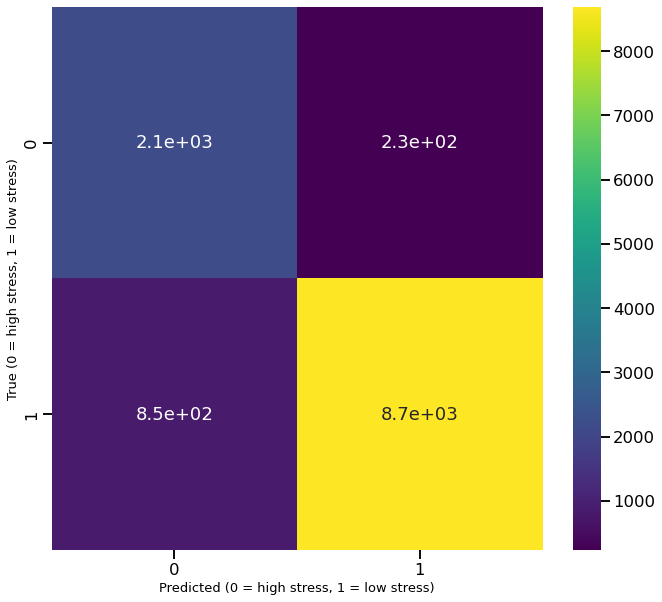

In [41]:
# Plot ROC and optimal F1
df_cm = pd.DataFrame(confusion_matrix(y_test_actual, y_test_pred))
fig = plt.figure(figsize=(11,10))
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.ylabel('True (0 = high stress, 1 = low stress)', fontsize=13)
plt.xlabel('Predicted (0 = high stress, 1 = low stress)', fontsize=13)

fig.savefig('all roads confusion.png', bbox_inches='tight')

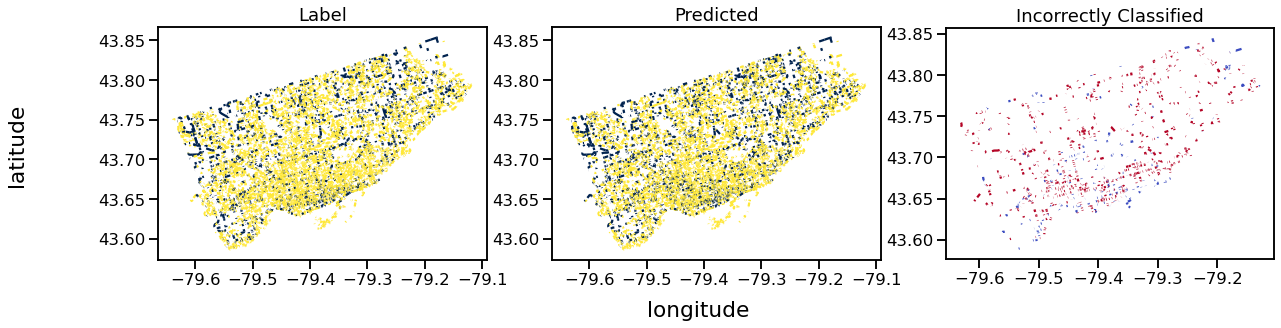

In [46]:
# Plot the above to show the new data. Show with 4 LTS and with the high/low access grouping
# Geoframe
plotr = pd.merge(lts_gpd,
                 predicted[['GEO_ID',0]],
                 how='left',
                 left_on='GEO_ID',
                 right_on='GEO_ID',)

# Find the difference in classification
plotr = plotr.dropna()
plotr['diff'] = plotr['high access'] - plotr[0]
plotr['i or c'] = plotr['diff'].apply(lambda x: 'incorrect' if x != 0 else 'correct')
plotr_diff = plotr[plotr['diff'] != 0]

# Figure
fig, axs = plt.subplots(figsize=(20,5), ncols=3)

# Plotting
plotr.plot(ax=axs[0], column='high access', cmap='cividis')
plotr.plot(ax=axs[1], column=0, cmap='cividis')
#plotr[plotr['i or c'] == 'incorrect'].plot(ax=axs[2], column='i or c', cmap='coolwarm')
plotr_diff.plot(ax=axs[2], column='diff', cmap='coolwarm')

# Attributes
axs[0].title.set_text('Label')
axs[1].title.set_text('Predicted')
axs[2].title.set_text('Incorrectly Classified')
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

fig.supxlabel('longitude')
fig.supylabel('latitude')

plt.show()

fig.savefig('all roads results.png', bbox_inches='tight')

#### Limited Roads model using intersection volume
import, train, test as above

In [15]:
import all_modes_model

In [16]:
# Import training data
train_data_2 = pd.read_csv('C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/allmodes_train.csv') #'allmodes_train.csv') 
train_data_2.head(2)

,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,...,truck volume from,ped volume from,car volume to,truck volume to,ped volume to,LTS str,high access,AREA_ID,pop_density,bike lane
0,293,12712,3897184,458,Bloor St W,13465391,13465411,0,47.382929,3897184,...,9.218450,61.362049,277.000000,25.500000,44.500000,1,1,2480059.0,8540.0,0
1,668,21756,906946,1012,Albion Rd,13452362,13452171,0,727.325603,906946,...,14.865056,29.730112,850.264994,22.409727,81.893645,4,0,101.0,NaN,0


In [18]:
model_2 = all_modes_model.train(train_data=train_data_2,
                                model_name='boost',
                                metrics=False,
                               )

[INFO] starting training.
Principal component 0
explains 71.72662319848223 % of the variance in "lon" and "lat".
Principal component 1
explains 28.273376801517774 % of the variance in "lon" and "lat".
[INFO] finished feature engineering.
[INFO] finished training gradient boosting model.
[INFO] skipping metrics.
[INFO] complete.


Predict and evaluate the final test set!

In [19]:
median = all_modes_model.extract_median_(train_data_2)

In [20]:
test_path = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/test_data/allmodes_test.csv'
test_data_2 = pd.read_csv(test_path)
print(test_data_2.shape)
test_data_2.head(2)

(318, 24)


,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,...,truck volume from,ped volume from,car volume to,truck volume to,ped volume to,LTS str,high access,AREA_ID,pop_density,bike lane
0,710,23229,444868,5218,Clayson Rd,13455060,13454642,0,329.411897,444868,...,19.342773,0.000000,39.760144,11.820583,1.074598,3,0,2480137.0,2337.0,0
1,1566,58555,7992892,2924,Avenue Rd,13461704,13461654,0,35.492528,7992892,...,18.436901,6.145634,531.085163,10.242723,13.827675,4,0,2480141.0,5683.0,0


In [21]:
y_test_pred_2, y_test_prob_2 = all_modes_model.predict(test_data_2, median, 
                                                       'boost', model=model_2,)

Principal component 0
explains 71.71181008304795 % of the variance in "lon" and "lat".
Principal component 1
explains 28.28818991695205 % of the variance in "lon" and "lat".
[INFO] finished feature engineering
[ERROR] modeltype randomforest has no "predict_proba_". Not returning
[INFO] complete.


In [22]:
print(y_test_pred_2[0:5])
y_test_actual_2 = test_data_2['high access']
y_test_actual_2.head()

[0 0 0 1 0]


0    0
1    0
2    0
3    1
4    0
Name: high access, dtype: int64

In [23]:
print(mean_squared_error(y_test_actual_2, y_test_pred_2))
print(f1_score(y_test_actual_2, y_test_pred_2, average='weighted'))
print(accuracy_score(y_test_actual_2, y_test_pred_2))

0.13522012578616352
0.8639643336946266
0.8647798742138365


In [24]:
confusion_matrix(y_test_actual_2, y_test_pred_2)

array([[215,  20],
       [ 23,  60]], dtype=int64)

In [25]:
predicted = pd.Series(y_test_pred_2)
predicted = pd.concat((test_data_2, predicted), axis=1)

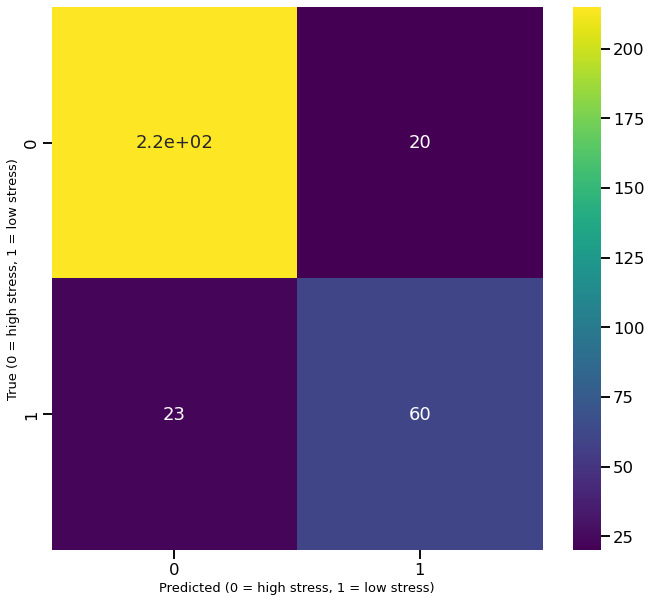

In [40]:
# Plot confusion matrix, roc, and optimal f1 if possible.
df_cm_2 = pd.DataFrame(confusion_matrix(y_test_actual_2, y_test_pred_2))
fig = plt.figure(figsize=(11,10))
sns.heatmap(df_cm_2, annot=True, cmap='viridis')
plt.ylabel('True (0 = high stress, 1 = low stress)', fontsize=13)
plt.xlabel('Predicted (0 = high stress, 1 = low stress)', fontsize=13)

fig.savefig('all modes confusion.png', bbox_inches='tight')

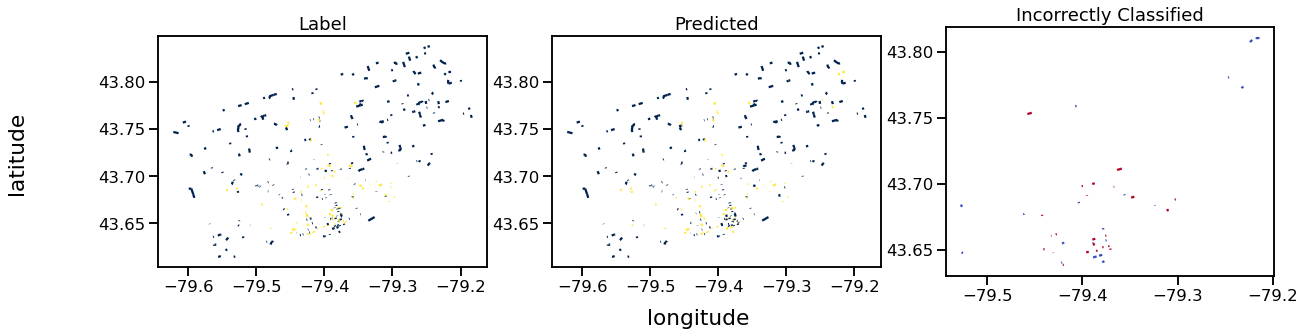

In [34]:
# Plot the above to show the new data. Show with 4 LTS and with the high/low access grouping
# Geoframe
plotr = pd.merge(lts_gpd,
                 predicted[['GEO_ID',0]],
                 how='left',
                 left_on='GEO_ID',
                 right_on='GEO_ID',)

# Find the difference in classification
plotr = plotr.dropna()
plotr['diff'] = plotr['high access'] - plotr[0]
plotr['i or c'] = plotr['diff'].apply(lambda x: 'incorrect' if x != 0 else 'correct')
plotr_diff = plotr[plotr['diff'] != 0]

# Figure
fig, axs = plt.subplots(figsize=(20,5), ncols=3)

# Plotting
plotr.plot(ax=axs[0], column='high access', cmap='cividis')
plotr.plot(ax=axs[1], column=0, cmap='cividis')
#plotr[plotr['i or c'] == 'incorrect'].plot(ax=axs[2], column='i or c', cmap='coolwarm')
plotr_diff.plot(ax=axs[2], column='diff', cmap='coolwarm')

# Attributes
axs[0].title.set_text('Label')
axs[1].title.set_text('Predicted')
axs[2].title.set_text('Incorrectly Classified')
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

fig.supxlabel('longitude')
fig.supylabel('latitude')

plt.show()
fig.savefig('all modes results.png', bbox_inches='tight')